In [39]:
using Distributed
using Plots
using LaTeXStrings
using HDF5
using Statistics
using StatsBase
using Random
addprocs(4)
@everywhere include("fluo_cont_meas_sim.jl")
@everywhere include("likelihood.jl")
@everywhere include("likelihood_strong.jl")
@everywhere include("fisher_cont_meas.jl")

In [40]:
FILENAME = "089_exp=4_prepared.h5"
global file = h5open(FILENAME, "r")

HDF5 data file: 089_exp=4_prepared.h5

In [3]:
# Experimental parameters
T1 = 15.0
TD = 5.0
Trabi = 2.
Tphi = 17.9

# Parameter dictionary to be passed to the functions
params = Dict( :Tfinal    => 20., # Final time
               :dt        => 0.1, # duration of infinitesimal time
               :Gamma1    => 1. / T1,   # Gamma fluoresence
               :GammaD    => 1. / TD,  # Gamma dephasing controllable
               :GammaPhi  => 1. / Tphi,  # Gamma dephasing not controllable
               :etavalF   => 0.14, # efficiency fluoresence heterodyne
               :etavalD   => 0.34, # efficiency dephasing homodyne
               :omegaTrue => 2 * pi / Trabi, # True value of omega
               :omegaMin  => 2., # minimum value of omega
               :omegaMax  => 4., # maximum value of omega
               :threshold => 0.375,
               :Nomega    => 500); # Resolution in omega for the Bayesian estimation

Fisher information as a benchmark

In [4]:
params_unconditional = copy(params)
params_unconditional[:etavalF] = 0.
params_unconditional[:etavalD] = 0.

#(tFisher, FisherAvgUncOmega15, QFisherAvgUncOmega15, FisherMAvgUncOmega15, QFisherEffUNCOmega15, FisherMEffUNCOmega15)
@time fisherUncResult = parallel_fluo_continuous_measurement_het_classic_initial0(10; Ntime=1000, params_unconditional...)
@time fisherResult = parallel_fluo_continuous_measurement_het_classic_initial0(5000; Ntime=1000, params...);

 11.225171 seconds (17.46 M allocations: 884.401 MiB, 6.57% gc time)
 99.502235 seconds (477.32 M allocations: 41.878 GiB, 7.80% gc time)


In [5]:
function rescale_experimental_data(x, factor=10^(-3/2))
    x .* factor
end

function load_z_data(file)
    OutZ = read(file["z"])
    CHUNK_SIZE = 10000
    chunk_n = Int(floor(length(OutZ) / CHUNK_SIZE))
    indices = vcat([1 + (-1 + 3 * i ) * CHUNK_SIZE : 3* i * CHUNK_SIZE for i in 1:chunk_n]...)
    print(size(OutZ))
    dyHet1 = read(file["u"])
    dyHet1 = rescale_experimental_data.(dyHet1[:,indices])
    print(size(dyHet1))
    dyHet2 = read(file["v"])
    dyHet2 = rescale_experimental_data.(dyHet2[:,indices])
    print(size(dyHet2))
    dyDep =  read(file["w"])
    dyDep = rescale_experimental_data.(dyDep[:,indices])
    print(size(dyDep))            
    return (dyHet1=dyHet1, dyHet2=dyHet2, dyDep=dyDep, OutZ=OutZ)
end

function sample_data(Ntraj, dataTuple)
    idx = sample(1:length(dataTuple.OutZ), Ntraj; replace=false, ordered=true)
    dyHet1 = dataTuple.dyHet1[:,idx]
    dyHet2 = dataTuple.dyHet2[:,idx]
    dyDep  = dataTuple.dyDep[:,idx]
    OutZ = dataTuple.OutZ[idx]
    return (dyHet1=dyHet1, dyHet2=dyHet2, dyDep=dyDep, OutZ=OutZ)
end

sample_data (generic function with 1 method)

Let's load all the data with the final $z$ measurement.

In [6]:
@time data = load_z_data(file)

(500000, 1)(197, 500000)(197, 500000)(197, 500000) 89.163046 seconds (1.82 M allocations: 6.701 GiB, 0.94% gc time)


(dyHet1 = [0.168347 -0.427909 … 0.414684 -0.381493; 0.221544 -0.184497 … -0.389542 0.0963835; … ; -0.225201 -0.26434 … 0.291038 -0.206455; 0.291843 -0.602129 … 0.0826972 -0.00187278], dyHet2 = [0.0357805 -0.227065 … -0.106864 -0.0950461; 0.1144 0.148625 … 0.21707 0.378605; … ; 0.18121 0.574529 … -0.235126 0.187622; 0.176519 -0.276415 … 0.833645 0.238279], dyDep = [0.102975 -0.0891396 … 0.0877286 -0.344715; 0.298414 -0.0630006 … 0.0653102 0.103935; … ; 0.249447 0.175985 … -0.373706 -0.485236; -0.534347 -0.0144465 … -0.606564 -0.414226], OutZ = [1.78583; -1.06456; … ; 1.66658; -0.980879])

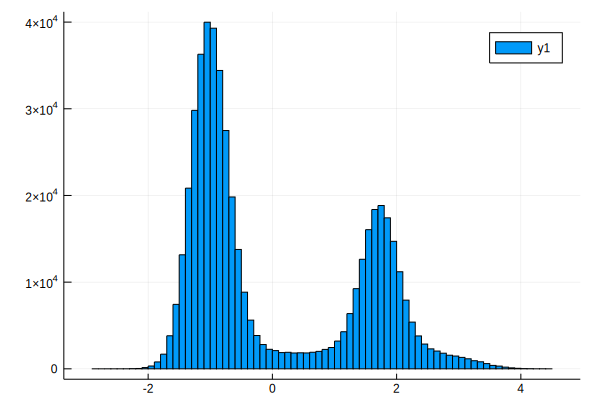

In [41]:
histogram(data[4])

## Keeping only the trajectories close to the peaks

Let's try to keep only the trajectories corresponding to measurement results around the two main peaks

In [8]:
peak1_low=-1.6
peak1_high=-.3
peak2_low=1.1
peak2_high=2.4
#the interval of measurement outcomes is the same around the two peaks: 1.3

strongmeas_filter= ((data[4][:].>peak2_low) .& (data[4][:].<peak2_high) ) .| ( (data[4][:].<peak1_high) .& (data[4][:].>peak1_low));
data_filter=(dyHet1=data[1][:,strongmeas_filter], dyHet2=data[2][:,strongmeas_filter], dyDep=data[3][:,strongmeas_filter], OutZ=data[4][strongmeas_filter])

(dyHet1 = [0.168347 -0.427909 … 0.414684 -0.381493; 0.221544 -0.184497 … -0.389542 0.0963835; … ; -0.225201 -0.26434 … 0.291038 -0.206455; 0.291843 -0.602129 … 0.0826972 -0.00187278], dyHet2 = [0.0357805 -0.227065 … -0.106864 -0.0950461; 0.1144 0.148625 … 0.21707 0.378605; … ; 0.18121 0.574529 … -0.235126 0.187622; 0.176519 -0.276415 … 0.833645 0.238279], dyDep = [0.102975 -0.0891396 … 0.0877286 -0.344715; 0.298414 -0.0630006 … 0.0653102 0.103935; … ; 0.249447 0.175985 … -0.373706 -0.485236; -0.534347 -0.0144465 … -0.606564 -0.414226], OutZ = [1.78583, -1.06456, -0.66924, 1.96082, -0.916057, -1.11882, 1.54004, -1.40566, -0.656114, -1.08264  …  -0.730902, -0.462783, -0.934119, 1.78173, 2.29065, -0.480888, -1.02736, -0.969382, 1.66658, -0.980879])

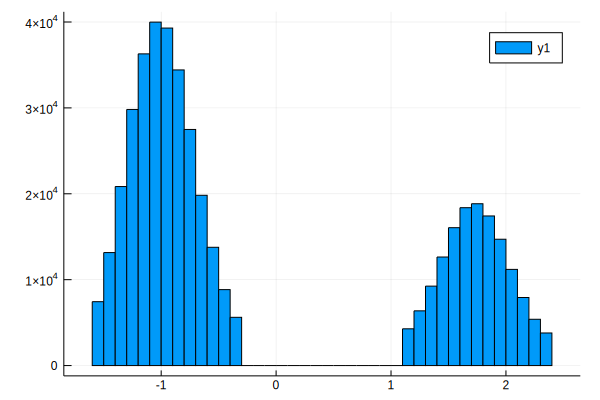

In [42]:
histogram(data_filter[4])

In [10]:
NTrajectories = 500
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(6)
sample_traj = sample_data(NTrajectories, data_filter);

In [11]:
@time resStrong = Likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);
#@time res = Likelihood(dyHet1, dyHet2, dyDep, 200; params...);

 15.797551 seconds (57.20 M allocations: 6.461 GiB, 10.47% gc time)


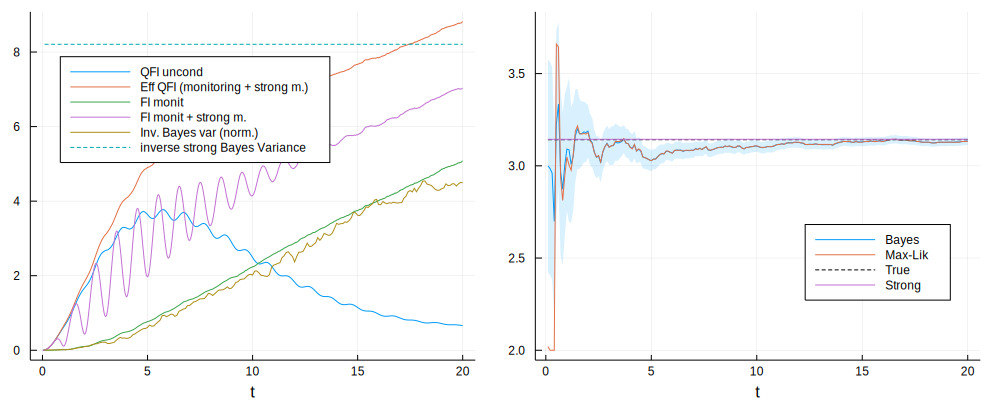

In [12]:
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(resStrong.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)

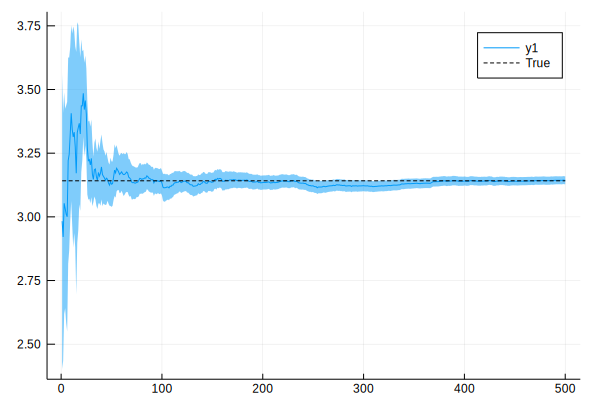

In [13]:
plot(resStrong.omegaEstStrong, ribbon=(resStrong.sigmaStrong, resStrong.sigmaStrong))
plot!(1:NTrajectories, fill(params[:omegaTrue], NTrajectories), style=:dash,  color=:black, label="True")

Let's try the same thing with other random trajectories

In [14]:
NTrajectories = 500
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(6)
sample_traj = sample_data(NTrajectories, data_filter);

In [15]:
@time resStrong = Likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);

 11.888158 seconds (51.84 M allocations: 6.213 GiB, 11.90% gc time)


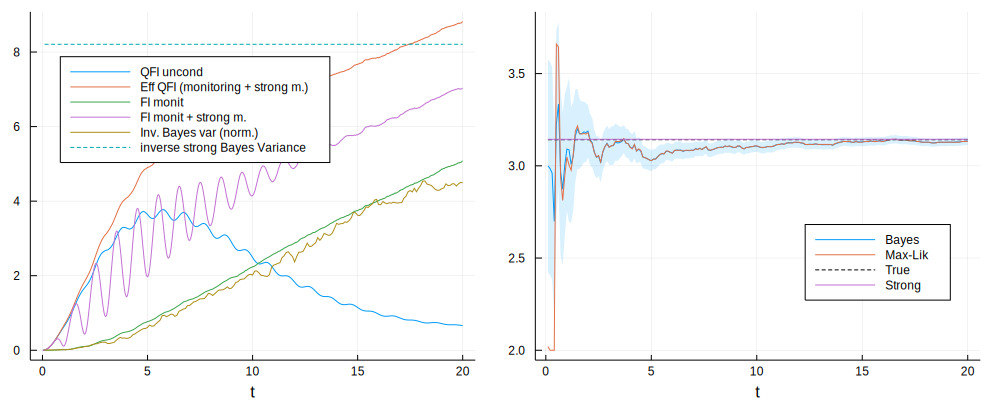

In [16]:
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(resStrong.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)

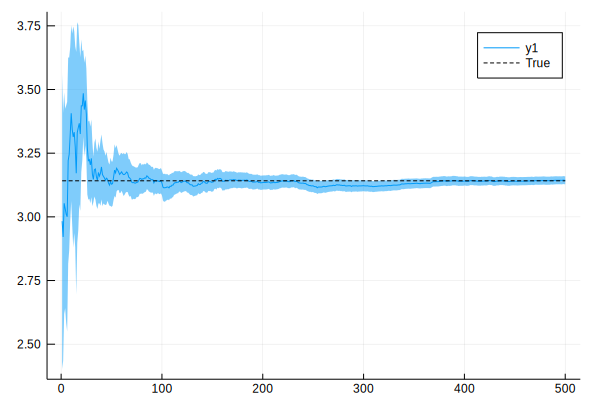

In [17]:
plot(resStrong.omegaEstStrong, ribbon=(resStrong.sigmaStrong, resStrong.sigmaStrong))
plot!(1:NTrajectories, fill(params[:omegaTrue], NTrajectories), style=:dash,  color=:black, label="True")

Now let's try the same thing with *MORE* random trajectories (1.5k)

In [18]:
NTrajectories = 1500
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(6)
sample_traj = sample_data(NTrajectories, data_filter);
@time resStrong = Likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);
#@time res = Likelihood(dyHet1, dyHet2, dyDep, 200; params...);

 33.971176 seconds (155.24 M allocations: 18.622 GiB, 11.43% gc time)


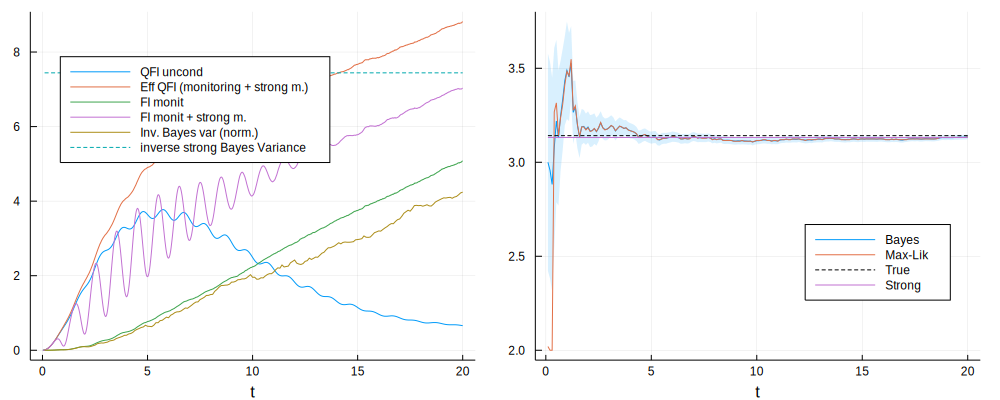

In [19]:
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(resStrong.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)

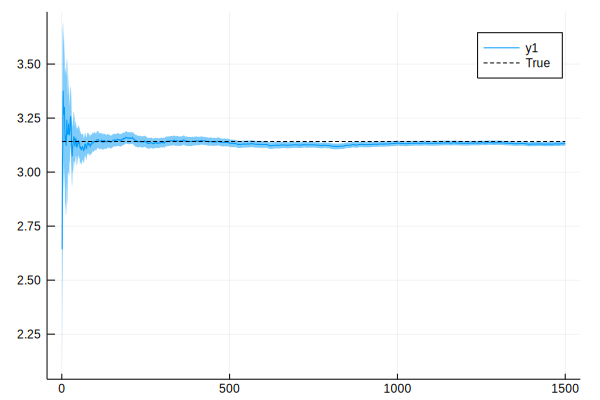

In [20]:
plot(resStrong.omegaEstStrong, ribbon=(resStrong.sigmaStrong, resStrong.sigmaStrong))
plot!(1:NTrajectories, fill(params[:omegaTrue], NTrajectories), style=:dash,  color=:black, label="True")

## 5k trajectories

In [ ]:
NTrajectories = 5000
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(6)
sample_traj = sample_data(NTrajectories, data_filter);
@time resStrong = Likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);

In [ ]:
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(resStrong.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)

In [ ]:
plot(resStrong.omegaEstStrong, ribbon=(resStrong.sigmaStrong, resStrong.sigmaStrong))
plot!(1:NTrajectories, fill(params[:omegaTrue], NTrajectories), style=:dash,  color=:black, label="True")

## Simulation with strong measurements

In [25]:
simParams = copy(params)
simParams[:dt] = 0.01
Ntime=Integer(simParams[:Tfinal]/simParams[:dt]);
NTrajectories = 2000
@time simData = parallel_fluo_continuous_measurement_het_simulation(NTrajectories; simParams...)

 10.224025 seconds (842.19 k allocations: 40.331 MiB, 0.82% gc time)


(t = 0.01:0.01:20.0, Ntime = 2000, dyHet1 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0802506 0.0510426 … -0.0169847 0.0679514; -0.122835 0.214216 … -0.0947719 0.0998137], dyHet2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.145506 0.23011 … -0.0765137 0.0632439; 0.143347 0.200039 … -0.00976708 -0.0905362], dyDep = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0100331 -0.0570576 … -0.0513644 0.0774711; 0.0481316 -0.0648091 … 0.0200034 0.123802], OutStrong = [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … 1.0 1.0; -1.0 -1.0 … -1.0 -1.0], AvgZcondTrue = [-0.919599 -0.918292 … 0.630092 0.643004; -0.919599 -0.918292 … -0.256648 -0.24327; … ; -0.919599 -0.918292 … -0.072182 -0.0793475; -0.919599 -0.918292 … -0.489824 -0.451723])

In [27]:
@time simStrong = Likelihood_strong(simData.dyHet1,simData.dyHet2, simData.dyDep, simData.OutStrong, Ntime; simParams...);

455.074545 seconds (2.05 G allocations: 245.437 GiB, 11.50% gc time)


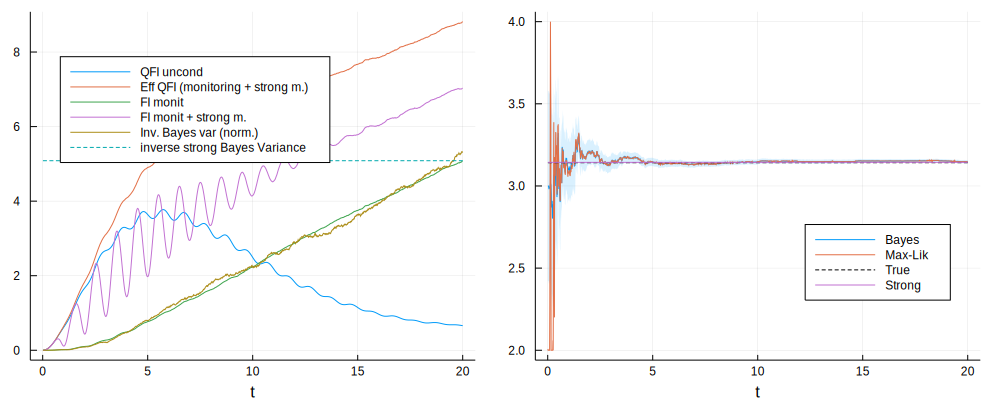

In [28]:
let resStrong = simStrong
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(resStrong.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)
end

In [38]:
simData.OutStrong

200×4000 Adjoint{Float64,SharedArray{Float64,2}}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0   1.0  -1.0  -1.0  -1.0   1.0
  1.0  -1.0   1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0   1.0
 -1.0   1.0   1.0   1.0   1.0   1.0     -1.0  -1.0  -1.0  -1.0   1.0  -1.0
 -1.0   1.0  -1.0   1.0  -1.0   1.0  …   1.0   1.0   1.0   1.0   1.0  -1.0
 -1.0  -1.0   1.0   1.0   1.0  -1.0      1.0  -1.0   1.0   1.0   1.0   1.0
  1.0   1.0   1.0   1.0   1.0   1.0      1.0   1.0  -1.0   1.0   1.0   1.0
  1.0   1.0   1.0   1.0   1.0   1.0      1.0   1.0  -1.0  -1.0   1.0   1.0
  1.0   1.0   1.0   1.0  -1.0   1.0     -1.0   1.0   1.0   1.0   1.0   1.0
  1.0   1.0   1.0   1.0   1.0   1.0  …   1.0   1.0   1.0   1.0   1.0   1.0
 -1.0   1.0   1.0  -1.0  -1.0   1.0      1.0   1.0  -1.0   1.0  -1.0   1.0
  1.0  -1.0   1.0  -1.0  -1.0   1.0      1.0   1.0